In [1]:
import os.path

import scanpy as sc
import scanpy.external as sce
from flecs.utils import set_seed, get_project_root
import random
import numpy as np
from flecs.sc.utils import compute_cell_knn_paths
import matplotlib.pyplot as plt
import seaborn as sns

sc.set_figure_params(figsize=(16, 8))
set_seed(0)

In [2]:
use_magic = True
normalize_per_cell = True
normalize_gene_std = False
use_log1p = False

## Load

In [3]:
adata = sc.read_h5ad(os.path.join(get_project_root(), 
                                  "datasets", "Paul15", "processed", "paul15_with_mouse_grn.h5ad")
                    )
# Restrict to relevant cell populations
adata = adata[adata.obs["Batch_desc"].apply(lambda n: n in ['Unsorted myeloid',
                                                            'CMP Flt3+ Csf1r+', 
                                                            'Cebpe KO', 
                                                            'Cebpa KO'])].copy()

In [4]:
adata.layers["counts"] = adata.X

## Highly variable genes

In [5]:
sc.pp.filter_genes(adata, min_counts=1)
if normalize_per_cell:
    sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')

# Find highly variable genes
if not use_log1p:
    adata_copy = sc.pp.log1p(adata, copy=True)
    sc.pp.highly_variable_genes(adata_copy, n_top_genes=4000, flavor='cell_ranger')  # Expects logged data

    adata.var['highly_variable'] = adata_copy.var['highly_variable']
else:
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor='cell_ranger')

In [6]:
adata.var['highly_variable']["Cebpa"]

True

In [7]:
adata.var['highly_variable']["Cebpe"]

True

In [8]:
adata.var['highly_variable'].sum()

4000

In [9]:
if use_magic:
    sce.pp.magic(adata, t=3, n_pca=300, verbose=True)

Calculating MAGIC...
  Running MAGIC on 7296 cells and 11757 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.72 seconds.
    Calculating KNN search...
    Calculated KNN search in 22.74 seconds.
    Calculating affinities...
    Calculated affinities in 22.92 seconds.
  Calculated graph and diffusion operator in 50.40 seconds.
  Running MAGIC with `solver='exact'` on 11757-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 20.49 seconds.
Calculated MAGIC in 70.97 seconds.


In [10]:
adata = adata[:, adata.var['highly_variable']].copy()
# Renormalize after filtering
if normalize_per_cell:
    sc.pp.normalize_per_cell(adata)
if normalize_gene_std:
    adata.X /= adata.X.std(axis=0)
    
adata.obs.reset_index(inplace=True)

In [11]:
np.sum(adata.varp["grn_adj_mat"])  / (adata.varp["grn_adj_mat"].shape[0]**2)

0.019434125

## Compute cell paths

In [11]:
def get_cell_indices(adata):
    # Get the indices of cells for the different populations
    cmp_cells = list(adata.obs[adata.obs["Batch_desc"] == 'CMP Flt3+ Csf1r+'].index.astype("int"))
    unsorted_cells = list(adata.obs[adata.obs["Batch_desc"] == 'Unsorted myeloid'].index.astype("int"))
    cebpa_cells = list(adata.obs[adata.obs["Batch_desc"] == 'Cebpa KO'].index.astype("int"))
    cebpe_cells = list(adata.obs[adata.obs["Batch_desc"] == 'Cebpe KO'].index.astype("int"))

    return cmp_cells, unsorted_cells, cebpa_cells, cebpe_cells

In [12]:
if use_magic:
    sc.tl.pca(adata, svd_solver="arpack", n_comps=200)
    sc.pp.neighbors(adata, n_neighbors=100, n_pcs=200)
    sc.tl.umap(adata, min_dist=0.3)
else:
    sc.tl.pca(adata, svd_solver="arpack", n_comps=200)
    sc.pp.neighbors(adata, n_neighbors=7, n_pcs=50)
    sc.tl.umap(adata, min_dist=0.3)

In [13]:
# Get cell indices coming from the different batches
cmp_cells, unsorted_cells, cebpa_cells, cebpe_cells = get_cell_indices(adata)
random.seed(0)
random.shuffle(cmp_cells)
random.shuffle(unsorted_cells)
random.shuffle(cebpa_cells)
random.shuffle(cebpe_cells)

unsorted_shortest_paths = compute_cell_knn_paths(adata, cmp_cells, unsorted_cells)
cebpa_ko_shortest_paths = compute_cell_knn_paths(adata, cmp_cells, cebpa_cells)
cebpe_ko_shortest_paths = compute_cell_knn_paths(adata, cmp_cells, cebpe_cells)

adata.uns["unsorted_shortest_paths"] = unsorted_shortest_paths
adata.uns["cebpa_ko_shortest_paths"] = cebpa_ko_shortest_paths
adata.uns["cebpe_ko_shortest_paths"] = cebpe_ko_shortest_paths

/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|██████████| 3072/3072 [02:50<00:00, 17.99it/s]
/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|██████████| 2304/2304 [03:14<00:00, 11.83it/s]
/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|██████████| 768/768 [00:23<00:00, 32.87it/s]


## Save

In [16]:
adata.layers["counts"].shape

(7296, 4000)

In [17]:
if use_magic:
    adata.write_h5ad(os.path.join(get_project_root(), "figure2", "adata_processed_with_paths_magic.h5ad"))
else:
    adata.write_h5ad(os.path.join(get_project_root(), "figure2", "adata_processed_with_paths.h5ad"))

## Plot

In [43]:
def plot_cell_type_distribution(adata, cell_type, root_cell=None, c="green"):
    assert c in ["green", "grey", "orange", "purple"]
    
    coords = adata[adata.obs["Batch_desc"] == cell_type].obsm['X_umap']

    if c == "green":
        plt.scatter(coords[:, 0], coords[:, 1], c="limegreen", alpha=0.9)
        sns.kdeplot(x=coords[:, 0], y=coords[:, 1], cmap="Greens")
    if c == "orange":
        plt.scatter(coords[:, 0], coords[:, 1], c="orange", alpha=0.2)
        sns.kdeplot(x=coords[:, 0], y=coords[:, 1], cmap="Oranges")
    if c == "purple":
        plt.scatter(coords[:, 0], coords[:, 1], c="purple", alpha=0.2)
        sns.kdeplot(x=coords[:, 0], y=coords[:, 1], cmap="Purples")
    else:
        plt.scatter(coords[:, 0], coords[:, 1], c="k", alpha=0.05)
        sns.kdeplot(x=coords[:, 0], y=coords[:, 1], cmap="Greys")

    if root_cell is not None:
        root_cell_coord = adata.obsm["X_umap"][root_cell]
        plt.scatter(root_cell_coord[0], root_cell_coord[1], marker='*', s=300, zorder=2, c="r")

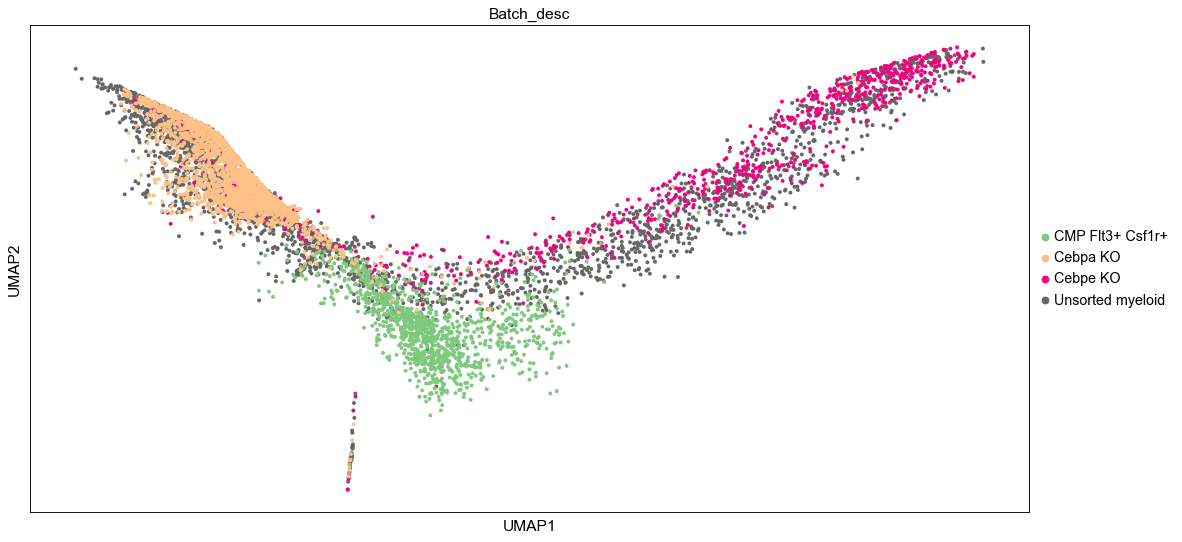

In [27]:
sc.pl.umap(adata, color="Batch_desc", palette="Accent", legend_loc='right margin', size=50)

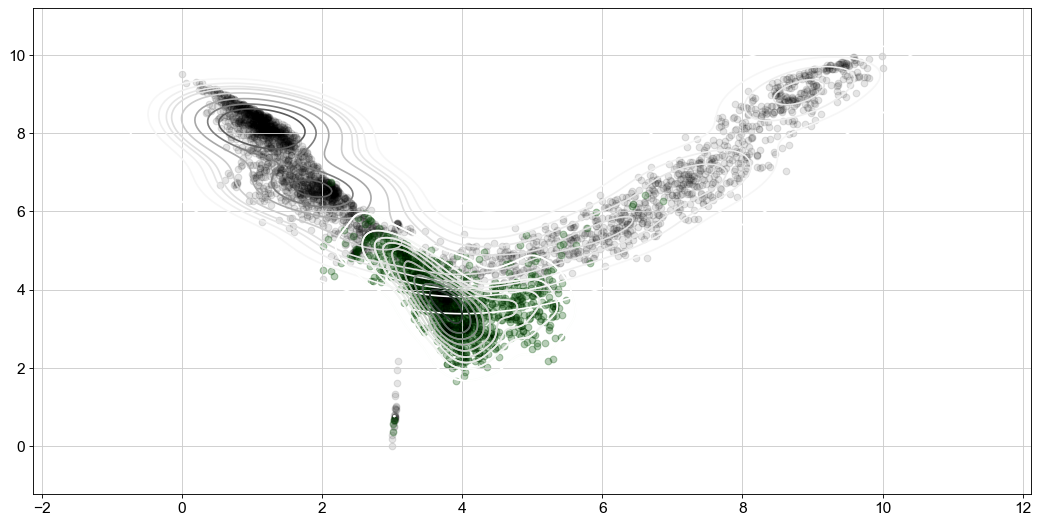

In [28]:
plot_cell_type_distribution(adata, 'Unsorted myeloid', c="grey")
plot_cell_type_distribution(adata, 'CMP Flt3+ Csf1r+', c="green")
plt.show()

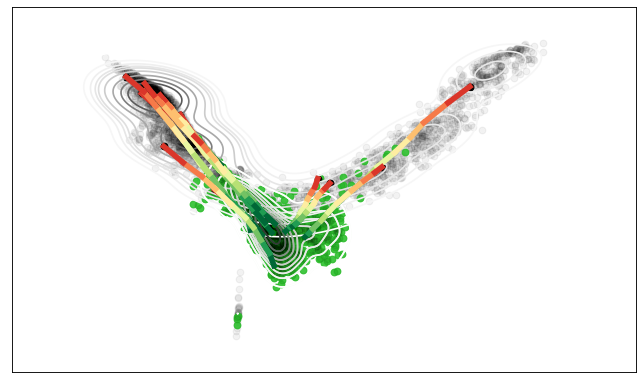

In [45]:
sc.set_figure_params(figsize=(10, 6))

plot_cell_type_distribution(adata, 'Unsorted myeloid', c="grey")
plot_cell_type_distribution(adata, 'CMP Flt3+ Csf1r+', c="green")

plt.xticks([], [])
plt.yticks([], [])

for i, path in enumerate(unsorted_shortest_paths.values()):
    if i % 200 == 1:

        path_coord = adata.obsm["X_umap"][path]

        MAP = 'RdYlGn_r'
        NPOINTS = len(path_coord)

        cm = plt.get_cmap(MAP)

        for i in range(NPOINTS-1):
            plt.plot(path_coord[i:i+2, 0], path_coord[i:i+2, 1], c=cm(1.0*i/(NPOINTS-1)), linewidth=5)

        plt.scatter(path_coord[0, 0], path_coord[0, 1], marker="o", c="g")
        plt.scatter(path_coord[-1, 0], path_coord[-1, 1], marker="o", c="k")

plt.show()

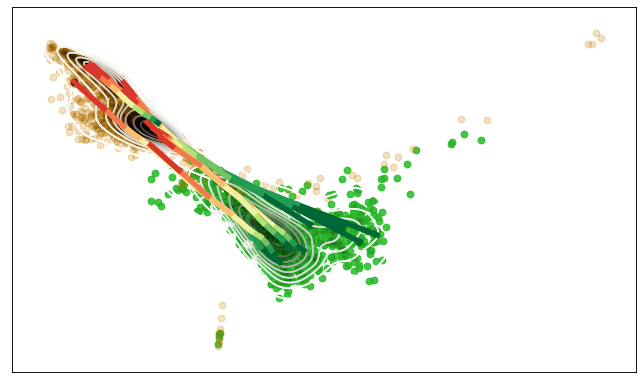

In [46]:
plot_cell_type_distribution(adata, 'CMP Flt3+ Csf1r+', c="green")
plot_cell_type_distribution(adata, 'Cebpa KO', c="orange")

plt.xticks([], [])
plt.yticks([], [])

for i, path in enumerate(cebpa_ko_shortest_paths.values()):
    if i % 200 == 1:
        path_coord = adata.obsm["X_umap"][path]
        
        MAP = 'RdYlGn_r'
        NPOINTS = len(path_coord)

        cm = plt.get_cmap(MAP)

        for i in range(NPOINTS-1):
            plt.plot(path_coord[i:i+2, 0], path_coord[i:i+2, 1], c=cm(1.0*i/(NPOINTS-1)), linewidth=5)

        plt.scatter(path_coord[0, 0], path_coord[0, 1], marker="o", c="g")
        plt.scatter(path_coord[-1, 0], path_coord[-1, 1], marker="o", c="k")

plt.show()

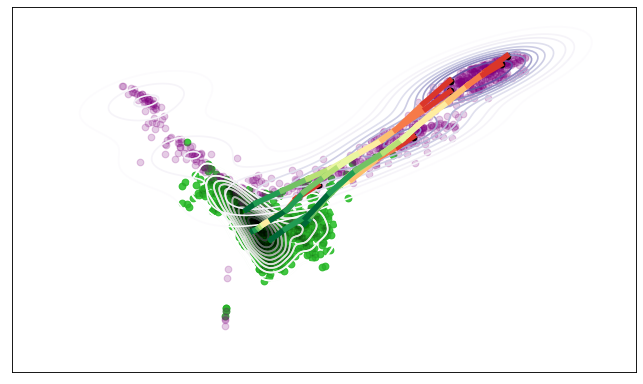

In [48]:
plot_cell_type_distribution(adata, 'CMP Flt3+ Csf1r+', c="green")
plot_cell_type_distribution(adata, 'Cebpe KO', c="purple")

plt.xticks([], [])
plt.yticks([], [])

for i, path in enumerate(cebpe_ko_shortest_paths.values()):
    if i % 100 == 1:
        path_coord = adata.obsm["X_umap"][path]
        
        MAP = 'RdYlGn_r'
        NPOINTS = len(path_coord)

        cm = plt.get_cmap(MAP)

        for i in range(NPOINTS-1):
            plt.plot(path_coord[i:i+2, 0], path_coord[i:i+2, 1], c=cm(1.0*i/(NPOINTS-1)), linewidth=5)

        plt.scatter(path_coord[0, 0], path_coord[0, 1], marker="o", c="g")
        plt.scatter(path_coord[-1, 0], path_coord[-1, 1], marker="o", c="k")

plt.show()